In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pyprind
import os
%matplotlib inline

In [298]:
import datasets.cifar10 as cifar10
trainX, trainY, vectTrainY, testX, testY, oneHotTestY, labels = cifar10.load()

In [299]:
mean, std = np.mean(trainX), np.std(trainX)

trainX = (trainX - mean)/std
#trainX = np.concatenate((np.ones(shape=(trainX.shape[0], 1), dtype=np.uint8), trainX), axis=1)

testX = (testX - mean)/std

In [231]:
np.random.rand(nn.n2)

array([ 0.13060388,  0.96619755,  0.72607353,  0.04044563,  0.78720754,
        0.32261273,  0.98574409,  0.51928905,  0.2064564 ,  0.40305478])

In [242]:
class ReLuNode:
    def forwardPropagation(self, x):
        self.x = x
        return np.maximum(0, x)
    def backPropagation(self):
        grad = np.array(self.x > 0, dtype = np.float32)
        return grad

class SigmoidNode:
    def forwardPropagation(self, x):
        self.x = x
        self.sigmoid = 1/(1 + np.exp(-1*x))
        return self.sigmoid
    def backPropagation(self):
        grad = self.sigmoid*(1 - self.sigmoid)
        return grad
    
class DropoutNode:
    p = 0.5
    def forwardPropagation(self, x):
        self.x = x
        self.f1 = np.random.rand(*x.shape) < self.p
        self.dropout = x*self.f1
        return self.dropout
    def backPropagation(self):
        grad = self.f1
        return grad
    
class SoftmaxLossNode:
    def forwardPropagation(self, x, vectY):
        self.x = x
        self.vectY = vectY
        self.f1 = np.exp(x)
        self.f2 = self.f1*vectY
        self.f3 = np.sum(self.f2, axis=0)
        self.f4 = np.sum(self.f1, axis=0)
        self.f5 = self.f3/self.f4
        self.f6 = -np.log(self.f5)
        self.f7 = np.sum(self.f6)
        self.softmaxLoss = self.f7/x.shape[1]
        return self.softmaxLoss
    def backPropagation(self):
        # 1
        df6 = np.ones(shape=self.f6.shape)
        # 2
        df5 = -df6/self.f5
        # 3
        df4 = -self.f3/(self.f4**2)*df5
        # 2
        df1 = np.ones(shape=self.f1.shape)*df4
        df3 = df5/self.f4
        self.df2 = np.ones(shape=self.f2.shape)*df3
        df1 += self.vectY*self.df2
        #1
        grad = self.f1*df1/self.x.shape[1]
        return grad
    
class TanhNode:
    def forwardPropagation(self, x):
        self.x = x
        self.tanh = np.tanh(x)
        return self.tanh
    def backPropagation(self):
        grad = 1 - self.tanh**2
        return grad
    
class MatrixMulNode:
    def forwardPropagation(self, X, A):
        self.A = A
        self.X = X
        mul = X.dot(A)
        return mul
    def backPropagation(self):
        grad = self.A
        return grad

class SquareErrorLossNode:
    def forwardPropagation(self, N, x, vectY):
        self.diff = x - vectY
        self.N = N
        return np.sum(self.diff**2)/N
    def backPropagation(self):
        return 2*self.diff/self.N
    
class HingeLossNode:
    def forwardPropagation(self, N, x, vectY):
        self.N = N
        self.vectY = vectY
        # 2
        self.f2 = x * vectY
        #3
        self.f3 = np.sum(self.f2, axis=0)
        #4
        self.f4 = x - self.f3 + 1
        #5
        self.f5 = self.f4*(1-vectY)
        #6
        self.f6 = np.maximum(self.f5, 0)
        #7
        self.f7 = np.sum(self.f6)
        #8
        self.f8 = self.f7/N
        
        loss = np.sum(self.f8)
        return loss
    
    def backPropagation(self):
        #8
        df7 = 1/self.N
        #7
        #df7 = np.ones(shape = self.f7.shape)
        df6 = np.ones(shape=self.f6.shape) * df7
        #6
        #df6 = np.ones(shape = self.f6.shape)
        df5 = np.array(self.f5 > 0, dtype = np.float32) * df6
        #5
        #df5 = np.ones(shape = self.f5.shape)
        df4 = df5*(1 - self.vectY)
        #4
        #df4 = np.ones(shape = self.f4.shape)
        df3 = -1*np.ones(shape=self.f3.shape)*np.sum(df4, axis = 0)
        #3+2
        df1 = df4
        df2 = df3
        df1 += df2*self.vectY
        
        grad = df1
        return grad

In [301]:
#%%writefile SVMClassifier.py
class NeuralNetworkClassifier:
    losses = []
    batchLosses = []
    
    def __init__(self, n1, n2, epochs=300, learningRate=0.00005, batchSize=250, l2=0.01):
        self.n1 = n1
        self.n2 = n2
        self.l2 = l2
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.lossNode = SoftmaxLossNode()
        self.matrixMulNode1 = MatrixMulNode()
        self.activation1 = self.activationNode()
        self.matrixMulNode2 = MatrixMulNode()
        self.activation2 = self.activationNode()
        self.dropoutNode = DropoutNode()
        
    def activationNode(self):
        return ReLuNode()
        
    def forwardPropagation(self, W1, W2, b1, b2, X, vectY):
        # 1
        self.f1 = self.matrixMulNode1.forwardPropagation(W1, X.T) + b1[:, np.newaxis]
        # 2
        self.f2 = self.activation1.forwardPropagation(self.f1)
        self.f25 = self.dropoutNode.forwardPropagation(self.f2)
        # 3
        self.f3 = self.matrixMulNode2.forwardPropagation(W2, self.f25) + b2[:, np.newaxis]
        # 4
        self.f4 = self.activation2.forwardPropagation(self.f3)
        # 5
        self.f5 = self.lossNode.forwardPropagation(self.f4, vectY)
        self.f6 = self.f5 + self.l2*(np.sum(W1**2) + np.sum(W1**2) + np.sum(b1**2) + np.sum(b2**2))
        
        loss = self.f6
        return loss
    
    def backPropagation(self, X, vectY):
        # 5
        df1 = self.lossNode.backPropagation()
        # 4
        df2 = self.activation2.backPropagation()*df1
        # 3
        df3 = df2.dot(self.matrixMulNode2.backPropagation().T)
        df31 = self.matrixMulNode2.X.T.dot(df2)
        # 2
        df4 = self.activation1.backPropagation()*df31*self.dropoutNode.dropout   
        # 1
        df5 = df4.dot(self.matrixMulNode1.backPropagation().T) 
        
        db2 = np.sum(df2, axis=1)
        db1 = np.sum(df4, axis=1)
        grad = (df5 + 2*self.l2*self.W1, df3 + 2*self.l2*self.W2, db1 + 2*self.l2*self.b1, db2 + 2*self.l2*self.b2)
        return grad
    
    def fit(self, X, y, validationFunc = None):
        self.losses = []
        self.trainAccuracies = []
        self.validationAccuracies = []
        self.validationAccuracy = None
        self.batchLosses = []
        self.labelsCardinality = y.shape[0]
        self.W1 = 0.02*np.random.randn(self.n1, X.shape[1])
        self.W2 = 0.02*np.random.randn(self.n2, self.n1)
        self.b1 = 0.02*np.ones(self.n1)
        self.b2 = 0.02*np.ones(self.n2)
        self.mu = 0.9
        self.vW1 = np.zeros(self.W1.shape)
        self.vW2 = np.zeros(self.W2.shape)
        self.vb1 = np.zeros(self.b1.shape)
        self.vb2 = np.zeros(self.b2.shape)
        yr = np.argmax(y, axis=0)
        self.validationAccuracy = 0
        
        bar = pyprind.ProgBar(self.epochs*len(X)/self.batchSize, bar_char='█', width=60, track_time=True, stream=1)
        for i in range(0, self.epochs):
            loss = self.forwardPropagation(self.W1, self.W2, self.b1, self.b2, X, y)
            self.trainAccuracy = np.sum(self.predict(X) == yr)/len(X)
            if validationFunc != None:
                self.validationAccuracy = validationFunc(self)
                self.validationAccuracies.append(self.validationAccuracy)
            self.losses.append(loss)
            self.trainAccuracies.append(self.trainAccuracy)           
            #logging.info(loss)
            indexes = np.arange(0, len(X))
            np.random.shuffle(indexes)
            trainX = X[indexes]
            trainY = y[:, indexes]
            for batch in range(0, len(X), self.batchSize):
                batchX = trainX[batch:batch+self.batchSize]
                batchY = trainY[:, batch:batch+self.batchSize]
                batchLoss = self.forwardPropagation(self.W1, self.W2, self.b1, self.b2, batchX, batchY) 
                self.batchLosses.append(batchLoss)
                gradW1, gradW2, gradb1, gradb2 = self.backPropagation(batchX, batchY)
                self.vW1 = self.mu*self.vW1 - self.learningRate*gradW1
                self.vW2 = self.mu*self.vW2 - self.learningRate*gradW2
                self.vb1 = self.mu*self.vb1 - self.learningRate*gradb1
                self.vb2 = self.mu*self.vb2 - self.learningRate*gradb2
                
                #self.W1 += -self.learningRate*gradW1
                #self.W2 += -self.learningRate*gradW2
                #self.b1 += -self.learningRate*gradb1
                #self.b2 += -self.learningRate*gradb2
                
                self.W1 += self.vW1
                self.W2 += self.vW2
                self.b1 += self.vb1
                self.b2 += self.vb2
                bar.update(item_id = "[%.3f, %.3f] %.2f, %.2f"%(self.trainAccuracy, self.validationAccuracy, loss, batchLoss))
        print(bar)
 
    def predictOneHot(self, X):
        activation = self.activationNode().forwardPropagation
        return activation(self.W2.dot(self.dropoutNode.p*activation(self.W1.dot(X.T) + self.b1[:, np.newaxis])) + self.b2[:, np.newaxis])

    def predict(self, X):
        return np.argmax(self.predictOneHot(X), axis=0)

In [309]:
nn = NeuralNetworkClassifier(50, 10, epochs=200, learningRate=0.001, l2=0)
nn.fit(trainX, vectTrainY, validationFunc = lambda model: np.sum(model.predict(testX) == testY)/len(testX))

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: [0.492, 0.471] 1.66, 1.74
Total time elapsed: 00:11:01
Title: 
  Started: 06/23/2016 20:19:00
  Finished: 06/23/2016 20:30:01
  Total time elapsed: 00:11:01


In [ ]:
#np.sum(nn.predict(trainX[:10]) == trainY[:10])/len(trainX[:10, :]), np.sum(nn.predict(testX) == testY)/len(testX)
np.sum(nn.predict(trainX) == trainY)/len(trainX), np.sum(nn.predict(testX) == testY)/len(testX)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].scatter(np.arange(0, len(nn.batchLosses)), nn.batchLosses)
plt.xlabel('Batch Epoch')
plt.ylabel('Batch Loss')

ax[0, 1].scatter(np.arange(0, len(nn.losses)), nn.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')


ax[1, 0].scatter(np.arange(0, len(nn.trainAccuracies)), nn.trainAccuracies, color='g')
ax[1, 0].axhline(1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

fig.set_size_inches((20, 15))

In [8]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder

/Users/kirill/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [9]:
digits = datasets.load_digits()

In [10]:
mnistTrainX = np.array(digits.data)
mnistTrainY = np.array(digits.target)
mnistOneHotTrainY = np.zeros(shape=(len(np.unique(mnistTrainY)), mnistTrainX.shape[0]))
for i in range(0, mnistTrainX.shape[0]):
    mnistOneHotTrainY[mnistTrainY[i], i] = 1
mnistMean, mnistStd = np.mean(mnistTrainX), np.std(mnistTrainX)

mnistTrainX = (mnistTrainX - mnistMean)/mnistStd

In [286]:
nn = NeuralNetworkClassifier(70, 10, epochs=900, learningRate=0.1, l2=0)
nn.fit(mnistTrainX[:1400, :], mnistOneHotTrainY[:, :1400])

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: [1.000, 0.000] 0.02, 0.00
Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:10

Total time elapsed: 00:00:11

Total time elapsed: 00:00:11

Total time 

In [287]:
np.sum(nn.predict(mnistTrainX) == mnistTrainY)/len(mnistTrainX), np.sum(nn.predict(mnistTrainX[1400:, :]) == mnistTrainY[1400:])/len(mnistTrainX[1400:, :])

(0.98720089037284364, 0.94206549118387906)

In [22]:
mnist2 = np.loadtxt('datasets/mnist/train.csv', skiprows=1, delimiter=',')

In [51]:
mnist2TrainX = mnist2[:32000, 1:]
mnist2TrainY = mnist2[:32000, 0]
mnist2TestX = mnist2[32000:, 1:]
mnist2TestY = mnist2[32000:, 0]

In [53]:
oneHotMnist2TrainY = np.zeros(shape=(len(np.unique(mnist2TrainY)), mnist2TrainX.shape[0]))
for i in range(0, mnist2TrainX.shape[0]):
    oneHotMnist2TrainY[mnist2TrainY[i], i] = 1
mnist2Mean, mnist2Std = np.mean(mnist2TrainX), np.std(mnist2TrainX)

mnist2TrainX = (mnist2TrainX - mnist2Mean)/mnist2Std
mnist2TestX = (mnist2TestX - mnist2Mean)/mnist2Std

oneHotMnist2TestY = np.zeros(shape=(len(np.unique(mnist2TrainY)), mnist2TestX.shape[0]))
for i in range(0, mnist2TestX.shape[0]):
    oneHotMnist2TestY[mnist2TestY[i], i] = 1

/Users/kirill/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/kirill/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [295]:
nn = NeuralNetworkClassifier(100, 10, epochs=1000, learningRate=0.01, l2=0.0001)
nn.fit(mnist2TrainX, oneHotMnist2TrainY,\
       validationFunc = lambda model: np.sum(model.predict(mnist2TestX) == mnist2TestY)/len(mnist2TestX))

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: [0.997, 0.975] 0.60, 0.62
Total time elapsed: 00:20:20
Title: 
  Started: 06/22/2016 22:07:07
  Finished: 06/22/2016 22:27:27
  Total time elapsed: 00:20:20


/Users/kirill/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


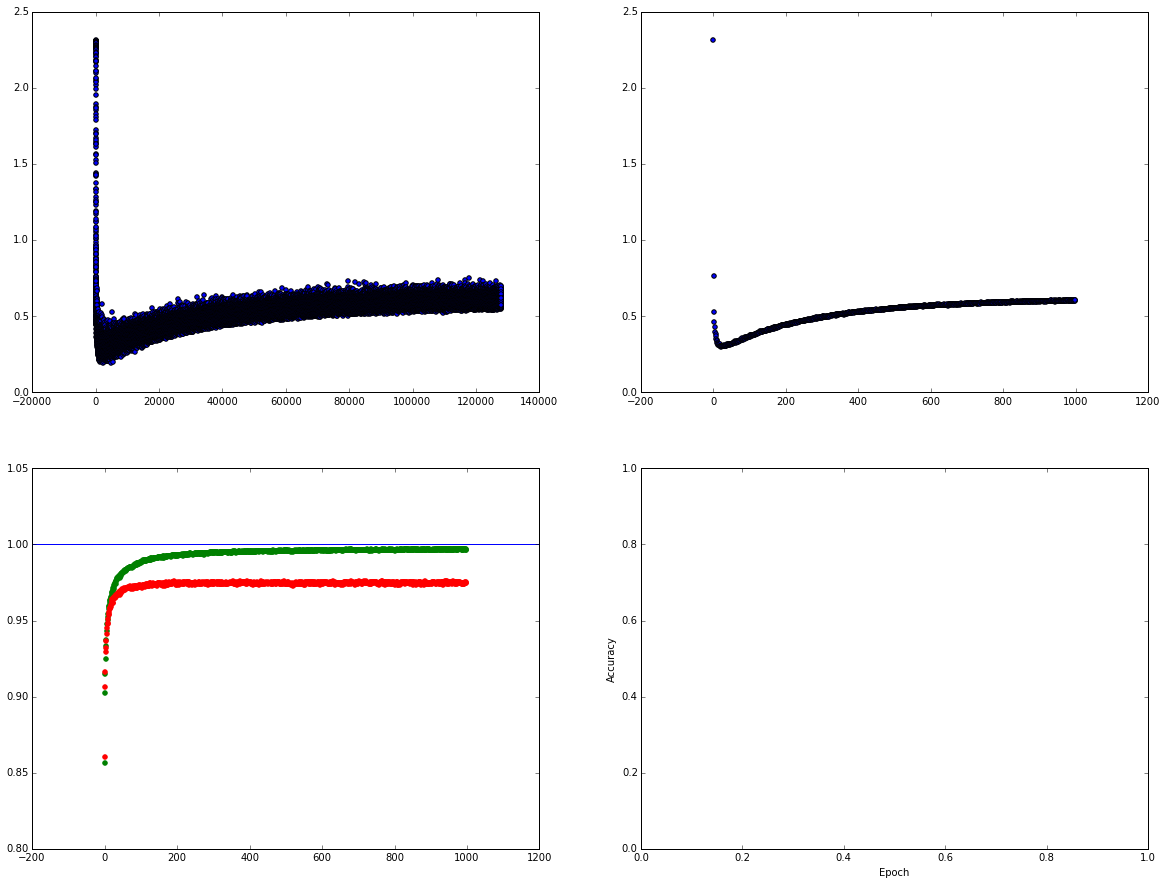

In [297]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].scatter(np.arange(0, len(nn.batchLosses)), nn.batchLosses)
plt.xlabel('Batch Epoch')
plt.ylabel('Batch Loss')

ax[0, 1].scatter(np.arange(0, len(nn.losses)), nn.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

trainAccuracies = np.array(nn.trainAccuracies)
trainAccuracies = trainAccuracies[np.where(trainAccuracies > 0.8)]
ax[1, 0].scatter(np.arange(0, len(trainAccuracies)), trainAccuracies, color='g')
validationAccuracies = np.array(nn.validationAccuracies)
validationAccuracies = validationAccuracies[np.where(validationAccuracies > 0.8)]
ax[1, 0].scatter(np.arange(0, len(validationAccuracies)), validationAccuracies, color='r')
ax[1, 0].axhline(1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

fig.set_size_inches((20, 15))

In [296]:
np.sum(nn.predict(mnist2TrainX) == mnist2TrainY)/len(mnist2TrainX), np.sum(nn.predict(mnist2TestX) == mnist2TestY)/len(mnist2TestX)

(0.99662499999999998, 0.9758)